# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'

# Data

## Universe: KOSPI200

In [3]:
k200 = DataManager(
    universe = 'kospi200',
    file = 'kospi200_prices_240707lst.csv',
    path = path_data
)
k200.upload()

200 assets from 2000-03-06 to 2024-07-05 uploaded.
df_prices updated


In [4]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [5]:
cond = df_k200.notna().sum(axis=1) > 170
df_k200 = df_k200.loc[cond].dropna(axis=1)
df_k200.columns.size

171

## testing

In [14]:
from pf_utils import get_file_latest, get_date_minmax
import pandas as pd
import os

### class

In [32]:
class FinancialRatios():
    def __init__(self, file, path='.', date_format='%Y-%m-%d',
                 cols_index={'date':'date', 'ticker':'ticker'},
                 ratios={'BPS':False, 'PER':True, 'PBR':True, 
                         'EPS':False, 'DIV':False, 'DPS':False}):
        self.file = get_file_latest(file, path) # latest file
        self.path = path
        self.date_format = date_format
        self.ratios = ratios # ratios and its ascending order
        self.cols_index = cols_index
        self.df_ratios = None
        return self.upload()


    def upload(self):
        """
        load financial ratios from a file
        """
        file = self.file
        path = self.path
        if file is None:
            return print('ERROR: Download first')

        f = os.path.join(path, file)
        if os.path.exists(f):
            col_ticker = self.cols_index['ticker']
            df_ratios = pd.read_csv(f, index_col=[0,1], parse_dates=[1], dtype={col_ticker:str})
            self.df_ratios = df_ratios
            return self._print_info(df_ratios, str_sfx='loaded')
        else:
            return print(f'WARNING: No \'{file}\' exists')
        

    def download(self, tickers, start, end=None, freq='m', save=True,
                 # args for TimeTracker.pause
                 interval=50, pause_duration=2, msg=False):
        col_date = self.cols_index['date']
        col_ticker = self.cols_index['ticker']
        if end is None:
            end = datetime.today().strftime(self.date_format)
        
        tracker = TimeTracker(auto_start=True)
        df_ratios = pd.DataFrame()
        
        for ticker in tqdm(tickers):
            df = pyk.get_market_fundamental(start, end, ticker, freq=freq)
            df = df.assign(**{col_ticker:ticker})
            df_ratios = pd.concat([df_ratios, df])
            tracker.pause(interval=interval, pause_duration=pause_duration, msg=msg)
        tracker.stop()
        
        df_ratios = (df_ratios.rename_axis(col_date)
                     .loc[df_ratios.index <= end] # remove fictitious end date of month
                     .set_index(col_ticker, append=True)
                     .swaplevel())
        self._print_info(df_ratios, str_sfx='downloaded')
        self.df_ratios = df_ratios
        if save:
            self.save(self.file, self.path)

    
    def save(self, file=None, path=None, date_format='%y%m%d'):
        """
        date_format: date format for file name
        """
        file = self._check_var(file, self.file)
        path = self._check_var(path, self.path)
        df_ratios = self.df_ratios
        if (file is None) or (df_ratios is None):
            return print('ERROR: check file or df_ratios')

        date = df_ratios.index.get_level_values(1).max().strftime(date_format)
        file = get_filename(file, f'_{date}', r"_\d+(?=\.\w+$)")
        _ = save_dataframe(df_ratios, file, path, msg_succ=f'{file} saved',
                           msg_fail=f'ERROR: failed to save as {file} exists')
        return None


    def get_ratios(self, date=None, metrics=None):
        """
        metrics: list or str
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        else:
            date = self._check_date(df_ratios, date)
            if date is None:
                return None

        if metrics is None:
            metrics = df_ratios.columns.to_list()

        col_date = self.cols_index['date']
        df_res = self._get_ratio(df_ratios, date, metrics).droplevel(col_date)

        metrics = '/'.join(metrics) if isinstance(metrics, list) else metrics
        print(f'{metrics} on {date}')
        return df_res
    

    def calc_rank(self, date=None, metrics='PER', topn=10, scale='minmax'):
        """
        calc the rank of financial ratios
        metrics: list or str
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        else:
            date = self._check_date(df_ratios, date)
            if date is None:
                return None

        if isinstance(metrics, str):
            metrics = [metrics]

        if len(metrics) > 1:
            if scale not in ['minmax', 'zscore']:
                return print('ERROR: Set scale to sum up multiple ranks')
        
        res_rank = None
        for m in metrics:
            sr_rank = self._calc_rank(df_ratios, date, m, scale)
            if res_rank is None:
                res_rank = sr_rank
            else:
                res_rank += sr_rank 
                
        metrics = '+'.join(metrics)
        s = metrics if topn is None else f'top {topn} stocks of low {metrics}'
        print(f'Ranking score of {s} on {date}')
        col_date = self.cols_index['date']
        return res_rank.droplevel(col_date).sort_values(ascending=True).iloc[:topn]


    def calc_historical(self, metrics='PER', scale='minmax'):
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        
        if isinstance(metrics, str):
            metrics = [metrics]
    
        try:
            df_r = df_ratios[metrics]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
        
        if len(metrics) > 1:
            if scale not in ['minmax', 'zscore']:
                return print('ERROR: Set scale to sum up multiple ranks')    
    
        col_date = self.cols_index['date']
        sr_historical = None
        for m in metrics:
            ascending = self.ratios[m]
            sr_h = self._calc_historical(df_r[m], ascending, scale, col_date)
            if sr_historical is None:
                sr_historical = sr_h
            else:
                sr_historical += sr_h

        metrics = '+'.join(metrics)
        print(f'Historical of {metrics} ranking score created')
        return sr_historical


    def interpolate(self, df_prices, metric='PER', freq='M'):
        """
        calculates an interpolated ratio for df_prices
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
    
        col_ticker = self.cols_index['ticker']
        col_date = self.cols_index['date']
        col_price='price'
        col_mpl = 'multiplier'
        col_ym = 'year_month'
        
        # Copy metric column to avoid modifying original
        df_m = df_ratios[metric].copy() 
        
        # Get price at the end date of every month
        by = [pd.Grouper(level=0), pd.Grouper(level=1, freq=freq)]
        df_p = df_prices.groupby(by).last().rename(col_price)
        
        # Update date index to year and month
        reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period(freq), level=1)
        df_m.index = reset_index(df_m)
        df_p.index = reset_index(df_p)
    
        # Calculate multiplier from price and metric
        df_m = (df_m.to_frame().join(df_p).dropna()
                .apply(lambda x: x[metric] / x[col_price], axis=1).rename(col_mpl))

        
        # interpolated ratio
        df_res = (df_prices.rename(col_price).reset_index(level=1)
                .assign(**{col_ym: lambda x: x[col_date].dt.to_period(freq)})
                .join(df_m, on=[col_ticker, col_ym])
                .set_index(col_date, append=True)
                .apply(lambda x: x[col_price] * x[col_mpl], axis=1)
                #.unstack(0)
               )
        dt0, dt1 = get_date_minmax(df_res, self.date_format, 1)
        print(f'{metric} interpolated from {dt0} to {dt1}')
        return df_res
    

    def _calc_historical(self, sr_ratio, ascending, scale, col_date):
        return (sr_ratio.groupby(level=col_date).rank(ascending=ascending)
                .groupby(level=col_date, group_keys=False).apply(lambda x: self._scale(x, scale))
               )
    

    def _get_ratio(self, df_ratios, date, metrics):
        """
        get financial ratios on date
        metrics: list or str
        """
        try:
            idx = pd.IndexSlice
            return df_ratios.loc[idx[:,date], metrics]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
        

    def _calc_rank(self, df_ratios, date, metric, scale, drop_zero=True):
        """
        calc the rank of a financial ratio
        metric: str
        """
        sr_ratio = self._get_ratio(df_ratios, date, metric)
        if sr_ratio is None:
            return # see _get_ratio for error msg
        
        if drop_zero:
           sr_ratio = sr_ratio.loc[sr_ratio>0]
            
        ascending = self.ratios[metric]
        sr_rank = sr_ratio.rank(ascending=ascending)
        return self._scale(sr_rank, scale)


    def _scale(self, sr_rank, scale):
        """
        scale rank
        """
        if scale == 'minmax':
            sr_rank = (sr_rank-sr_rank.min()) / (sr_rank.max()-sr_rank.min())
        elif scale == 'zscore':
            sr_rank  = (sr_rank-sr_rank.mean()) / sr_rank.std()
        else:
            pass
        return sr_rank


    def _check_date(self, df_ratios, date, return_str=True):
        """
        date: set date for ratios in df_ratios.
              'start' for the earlist date in df_ratios, 
              'end' or None for the latest date,
        """
        dates = df_ratios.index.get_level_values(1).unique()
        if date == 'start':
            date = dates.min()
        elif date in [None, 'end']:
            date = dates.max()
        else:
            cond = dates <= date
            if cond.any():
                date = dates[cond].max()
            else:
                date = dates.min()
                print(f'WARNING: date set to {date.strftime(self.date_format)}')
        
        if return_str:
            date = date.strftime(self.date_format)
        return date

    
    def _print_info(self, df, str_pfx='Financial ratios of', str_sfx=''):
        dt0, dt1 = get_date_minmax(df, self.date_format, 1)
        n = df.index.get_level_values(0).nunique()
        s1  = str_pfx + " " if str_pfx else ""
        s2  = " " + str_sfx if str_sfx else ""
        return print(f'{s1}{n} stocks from {dt0} to {dt1}{s2}')
        

    def _check_var(self, var_arg, var_self):
        return var_self if var_arg is None else var_arg


    def util_reshape(self, ):

## Ratios

In [33]:
WidgetUniverse

In [34]:
file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)

Financial ratios of 171 stocks from 2017-05-31 to 2024-09-30 loaded


In [35]:
start = df_k200.index.min()
#tickers = df_k200.columns.to_list()[:3]
tickers = df_k200.columns.to_list()

fr.download(tickers, start) if WidgetUniverse.values(0) else None

In [92]:
fr.df_ratios

BPS    PER   PBR     EPS   DIV    DPS
ticker date                                                 
005930 2017-05-31  1156530  14.43  1.97  157967  1.25  28500
       2017-06-30  1156530  14.14  1.93  157967  1.28  28500
       2017-07-31  1156530  14.95  2.04  157967  1.21  28500
       2017-08-31  1156530  15.38  2.10  157967  1.17  28500
       2017-09-30  1156530  14.71  2.01  157967  1.23  28500
...                    ...    ...   ...     ...   ...    ...
000670 2024-05-31  2216785   0.00  0.18       0  2.48  10000
       2024-06-30  2216785   0.00  0.17       0  2.66  10000
       2024-07-31  2216785   0.00  0.15       0  2.95  10000
       2024-08-31  2216785   0.00  0.14       0  3.17  10000
       2024-09-30  2216785   0.00  0.14       0  3.23  10000

[15219 rows x 6 columns]

In [36]:
fr.calc_rank(metrics='PER', date='start', topn=None)

Ranking score of PER on 2017-05-31


ticker
081660    0.000000
002710    0.006667
015760    0.013333
000270    0.020000
006650    0.026667
            ...   
009420    0.973333
009150    0.980000
008930    0.986667
011070    0.993333
241560    1.000000
Name: PER, Length: 151, dtype: float64

In [37]:
fr.calc_historical()

Historical of PER ranking score created


ticker  date      
005930  2017-05-31    0.489097
        2017-06-30    0.464174
        2017-07-31    0.495327
        2017-08-31    0.501558
        2017-09-30    0.489097
                        ...   
000670  2024-05-31    0.000000
        2024-06-30    0.000000
        2024-07-31    0.000000
        2024-08-31    0.000000
        2024-09-30    0.000000
Name: PER, Length: 15219, dtype: float64

In [38]:
df = df_k200.stack().swaplevel().rename_axis(['ticker','date']).sort_index()
df

ticker  date      
000080  2017-05-10     21600.0
        2017-05-11     21700.0
        2017-05-12     21700.0
        2017-05-15     21850.0
        2017-05-16     21900.0
                        ...   
267260  2024-07-01    296500.0
        2024-07-02    317000.0
        2024-07-03    318500.0
        2024-07-04    311000.0
        2024-07-05    312000.0
Length: 301131, dtype: float64

In [39]:
df_ratio = fr.interpolate(df)
df_ratio = df_ratio.unstack(0)
df_ratio

PER interpolated from 2017-05-10 to 2024-07-05


ticker,000080,000100,000120,000150,000210,000240,000270,000660,000670,000720,...,178920,180640,185750,192080,192820,204320,207940,241560,267250,267260
date,,,,,,,,,,,,,,,,,,,,,
2017-05-10,34.988430,15.443597,52.279636,8.400294,10.240687,7.347578,4.853393,12.963579,9.064686,10.524030,...,23.045657,0.000000,28.135634,20.114998,47.132113,11.012791,0.000000,20388.739946,0.000000,0.000000
2017-05-11,35.150413,15.603370,53.890494,8.637437,10.278792,7.453046,4.954225,13.150105,9.179429,10.878581,...,22.726465,0.000000,28.707464,20.326323,48.986675,11.012791,0.000000,20179.624665,0.000000,0.000000
2017-05-12,35.150413,15.572025,52.279636,8.552728,10.278792,7.294844,4.907170,12.893632,9.198552,10.812088,...,22.534949,0.000000,28.364366,19.727291,40.487281,11.057558,0.000000,20231.903485,0.000000,0.000000
2017-05-15,35.393388,15.507593,51.693870,8.679792,10.291588,7.189376,4.947503,12.963579,9.227238,10.657015,...,22.471111,0.000000,28.364366,19.656988,40.178293,11.169477,0.000000,20231.903485,0.000000,0.000000
2017-05-16,35.474380,15.282953,52.572519,8.679792,10.278792,7.242110,4.960948,12.893632,9.160305,10.878581,...,21.960404,0.000000,27.449438,19.762650,40.178293,10.811337,0.000000,20101.206434,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,41.720491,43.229564,9.387152,0.000000,0.000000,7.606781,5.905622,0.000000,0.000000,7.243636,...,0.000000,10.453410,5.967153,6.046205,39.536219,16.270800,59.529041,5.792863,20.121186,39.134199
2024-07-02,41.120197,39.721676,9.131049,0.000000,0.000000,7.488003,5.676010,0.000000,0.000000,7.025455,...,0.000000,10.243696,5.954925,6.066007,38.490841,15.779400,63.529016,5.668891,20.148414,41.839936
2024-07-03,40.920098,40.753408,9.288651,0.000000,0.000000,7.483053,5.680602,0.000000,0.000000,7.025455,...,0.000000,10.275960,5.961039,5.966997,37.424555,15.797600,63.529016,5.595635,20.420690,42.037917


# Backtest

In [40]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [41]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [42]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [43]:
select = 'f-ratio'
kwargs_build = dict(
    name=f'{select}', select =select,
    n_assets=10, weigh='Equally', freq='Y',
    df_ratio=df_ratio, ratio_ascending=True
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, f-ratio


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

Returning stats


,f-ratio,KODEX200
start,2017-05-09,2017-05-09
end,2024-07-05,2024-07-05
total_return,1.391805,0.545298
cagr,0.129585,0.062699
calmar,0.272487,0.164837
max_drawdown,-0.475562,-0.38037
avg_drawdown,-0.055322,-0.04033
avg_drawdown_days,62.325,78.46875
daily_vol,0.249818,0.18247
daily_sharpe,0.624385,0.432459


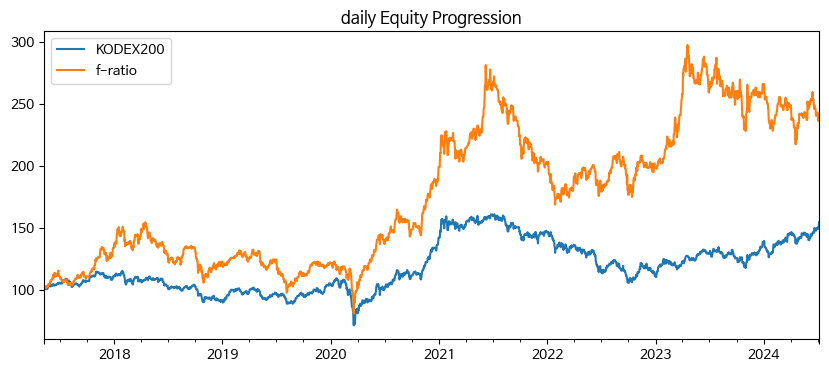

In [44]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [45]:
bm.portfolios

0) KODEX200
1) f-ratio

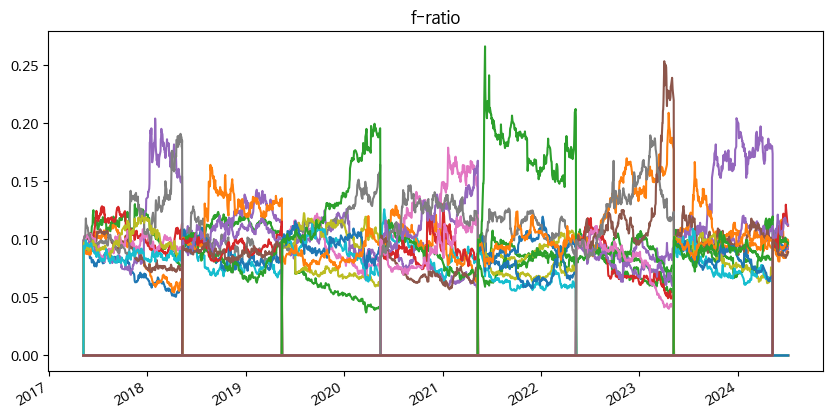

In [46]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [47]:
n_test = 250
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test-250:]

In [48]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [81]:
bm = BacktestManager(df_train, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [82]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [83]:
from itertools import product

params = dict(
    p_ast = [5,10,20,30],
    p_freq = [130, 250, 500]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'f-ratio:a{x[0]}/f{x[1]}','n_assets':x[0], 'freq':x[1]} for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally',
    df_ratio=df_ratio, ratio_ascending=False
)
bm.build_batch(*kwa_list, **kwargs_build)

In [84]:
df_res = bm.run(stats_sort_by='monthly_sharpe', plot=False)
df_res.iloc[:, :5]

Backtesting 13 strategies: KODEX200, f-ratio:a5/f130, ... , f-ratio:a30/f500


100%|███████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]

Returning stats


,f-ratio:a5/f500,f-ratio:a5/f130,f-ratio:a10/f500,f-ratio:a10/f130,f-ratio:a5/f250
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2023-06-28,2023-06-28,2023-06-28,2023-06-28,2023-06-28
total_return,2.388793,1.551276,1.273431,1.153287,1.182958
cagr,0.220083,0.164918,0.143231,0.133159,0.135689
calmar,0.524536,0.314144,0.329456,0.276895,0.271402
max_drawdown,-0.419577,-0.524978,-0.434749,-0.480899,-0.499955
avg_drawdown,-0.05531,-0.048668,-0.05564,-0.043941,-0.060596
avg_drawdown_days,41.66,34.733333,58.833333,40.365385,57.72973
daily_vol,0.269436,0.250739,0.232347,0.218663,0.262187
daily_sharpe,0.890183,0.748523,0.705987,0.694884,0.627312


In [85]:
bm.portfolios

0) KODEX200
1) f-ratio:a5/f130
2) f-ratio:a5/f250
3) f-ratio:a5/f500
4) f-ratio:a10/f130
5) f-ratio:a10/f250
6) f-ratio:a10/f500
7) f-ratio:a20/f130
8) f-ratio:a20/f250
9) f-ratio:a20/f500
10) f-ratio:a30/f130
11) f-ratio:a30/f250
12) f-ratio:a30/f500

In [91]:
pf_list = [0, 3, 1, 6, 4]
bm.get_stats(pf_list, sort_by='monthly_sharpe')

,f-ratio:a5/f500,f-ratio:a5/f130,f-ratio:a10/f500,f-ratio:a10/f130,KODEX200
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2023-06-28,2023-06-28,2023-06-28,2023-06-28,2023-06-28
total_return,2.388793,1.551276,1.273431,1.153287,0.290628
cagr,0.220083,0.164918,0.143231,0.133159,0.042459
calmar,0.524536,0.314144,0.329456,0.276895,0.111625
max_drawdown,-0.419577,-0.524978,-0.434749,-0.480899,-0.38037
avg_drawdown,-0.05531,-0.048668,-0.05564,-0.043941,-0.04033
avg_drawdown_days,41.66,34.733333,58.833333,40.365385,66.8125
daily_vol,0.269436,0.250739,0.232347,0.218663,0.184606
daily_sharpe,0.890183,0.748523,0.705987,0.694884,0.322683


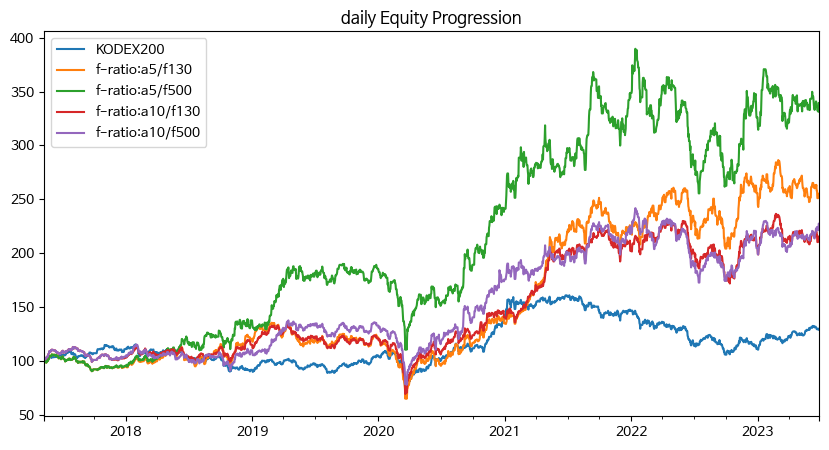

In [67]:
_ = bm.plot(figsize=(10,5))

# testing

## algo

In [50]:
import bt
import pandas as pd

data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')
sma = data.rolling(50).mean()


# first we create the Strategy
s = bt.Strategy('above50sma', [bt.algos.SelectWhere(data > sma),
                               #bt.algos.SetStat("test_stat"),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [51]:
data > sma

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,False,False,False,False,False
2010-01-05,False,False,False,False,False
2010-01-06,False,False,False,False,False
2010-01-07,False,False,False,False,False
2010-01-08,False,False,False,False,False
...,...,...,...,...,...
2024-10-07,False,False,True,True,True
2024-10-08,True,False,True,True,True
2024-10-09,True,False,True,True,True


In [65]:
s.setup(data, 
        test_stat=data, 
        test_stat2=data
       )

s.get_data('test_stat2')

,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,6.454506,23.347322,26.157930,133.968063,53.996017
2010-01-05,6.465663,23.354860,27.158087,136.336578,54.275620
2010-01-06,6.362818,23.211535,28.004385,134.881424,53.996017
2010-01-07,6.351058,22.970137,28.081303,137.520905,56.791931
2010-01-08,6.393281,23.128555,27.619696,134.920135,58.015137
...,...,...,...,...,...
2024-10-07,221.690002,409.540009,62.599998,494.619995,185.960007
2024-10-08,225.770004,414.709991,63.240002,496.570007,187.470001
2024-10-09,229.539993,417.459991,64.120003,505.179993,189.279999


In [56]:
# now we create the Backtest
t = bt.Backtest(s, data, 
                additional_data={'test_stat':data, 'test_stat2':data}
               )

# and let's run it!
res = bt.run(t)

s.get_data('test_stat2')
#res.plot()

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


,aapl,msft,c,gs,ge
Date,,,,,
2010-01-04,6.454506,23.347322,26.157930,133.968063,53.996017
2010-01-05,6.465663,23.354860,27.158087,136.336578,54.275620
2010-01-06,6.362818,23.211535,28.004385,134.881424,53.996017
2010-01-07,6.351058,22.970137,28.081303,137.520905,56.791931
2010-01-08,6.393281,23.128555,27.619696,134.920135,58.015137
...,...,...,...,...,...
2024-10-07,221.690002,409.540009,62.599998,494.619995,185.960007
2024-10-08,225.770004,414.709991,63.240002,496.570007,187.470001
2024-10-09,229.539993,417.459991,64.120003,505.179993,189.279999


In [72]:
s = bt.Strategy("s")

dts = pd.date_range("2010-01-01", periods=3)
data = pd.DataFrame(index=dts, columns=["c1", "c2"], data=100.0)
data.loc[dts[1], "c1"] = 105
data.loc[dts[1], "c2"] = 95

stat = pd.DataFrame(index=dts, columns=["c1", "c2"], data=4.0)
stat.loc[dts[1], "c1"] = 5.0
stat.loc[dts[1], "c2"] = 6.0

algo = bt.algos.SetStat("test_stat")
s.setup(data, test_stat=stat)
s.update(dts[0])
print()
print(s.get_data("test_stat"))
assert algo(s)


             c1   c2
2010-01-01  4.0  4.0
2010-01-02  5.0  6.0
2010-01-03  4.0  4.0


In [73]:
algo(s)

True

In [44]:
data

,c1,c2
2010-01-01,100.0,100.0
2010-01-02,105.0,95.0
2010-01-03,100.0,100.0


In [45]:
stat

,c1,c2
2010-01-01,4.0,4.0
2010-01-02,5.0,6.0
2010-01-03,4.0,4.0


In [ ]:
stat = s.temp["stat"]
assert stat["c1"] == 4.0
assert stat["c2"] == 4.0

s.update(dts[1])
assert algo(s)
stat = s.temp["stat"]
assert stat["c1"] == 5.0
assert stat["c2"] == 6.0


             c1   c2
2010-01-01  4.0  4.0
2010-01-02  5.0  6.0
2010-01-03  4.0  4.0


In [41]:
data

,c1,c2
2010-01-01,100.0,100.0
2010-01-02,105.0,95.0
2010-01-03,100.0,100.0


In [42]:
stat

c1    5.0
c2    6.0
Name: 2010-01-02 00:00:00, dtype: float64

In [ ]:
import bt

def _select_with_ratio(self, df_ratio):
    bt.algos.SetStat(stat)
    bt.algos.SelectWhere(df_ratio > 0)
    bt.algos.SelectN(n, sort_descending=True, all_or_none=False, filter_selected=False)


    s.setup(data, 
            test_stat=data, 
            test_stat2=data
           )
    
    s.get_data('test_stat2')

In [66]:
from bt.core import Algo, AlgoStack
import pandas as pd
import bt
from bt.algos import SelectN


class AlgoSelectFinRatio(AlgoStack):
    """
    Sets temp['selected'] based on a financial ratio filter.
    """
    def __init__(
        self,
        df_ratio,
        n,
        sort_descending=False,
        all_or_none=False,
    ):
        super(AlgoSelectFinRatio, self).__init__(
            AlgoStatFinRatio(df_ratio),
            SelectN(n=n, sort_descending=sort_descending, all_or_none=all_or_none),
        )


class AlgoStatFinRatio(Algo):
    """
    Sets temp['stat'] with financial ratio
    """
    def __init__(self, df_ratio):
        super(AlgoStatFinRatio, self).__init__()
        self.df_ratio = df_ratio

    def __call__(self, target):
        stat = self.df_ratio.loc[target.now]
        stat = stat.loc[stat > 0]
        if len(stat) == 0:
            return False
        target.temp["stat"] = stat
        return True


In [67]:
df_ratios = fr.df_ratios['PER'].copy()
df_ratios = df_ratios.unstack(0)
df_ratios

ticker,000660,005380,005930
date,,,
2017-05-31,13.29,7.78,14.43
2017-06-30,13.48,8.23,14.14
2017-07-31,15.85,8.13,14.95
2017-08-31,15.65,7.23,15.38
2017-09-30,16.42,7.11,14.71
...,...,...,...
2024-05-31,0.00,5.45,36.60
2024-06-30,0.00,5.80,35.52
2024-07-31,0.00,6.26,38.39


In [68]:
tickers = fr.df_ratios.index.get_level_values(0).unique()
df_prc = df_k200[tickers]
df_prc = df_prc.unstack().rename_axis(['ticker','date'])
df_r = fr.interpolate(df_prc)
df_r = df_r.unstack(0)
df_r

ticker,000660,005380,005930
date,,,
2017-05-10,12.963579,7.469755,14.720537
2017-05-11,13.150105,7.517485,14.688255
2017-05-12,12.893632,7.398160,14.791557
2017-05-15,12.963579,7.350429,14.881946
2017-05-16,12.893632,7.517485,14.972336
...,...,...,...
2024-07-01,0.000000,6.371388,36.053984
2024-07-02,0.000000,6.070641,36.053984
2024-07-03,0.000000,6.148612,36.053984


In [69]:
df_data = df_k200[df_r.columns]
df_data

,000660,005380,005930
Date,,,
2017-05-10,55600.0,156500.0,45600.0
2017-05-11,56400.0,157500.0,45500.0
2017-05-12,55300.0,155000.0,45820.0
2017-05-15,55600.0,154000.0,46100.0
2017-05-16,55300.0,157500.0,46380.0
...,...,...,...
2024-07-01,235500.0,286000.0,81800.0
2024-07-02,232000.0,272500.0,81800.0
2024-07-03,236000.0,276000.0,81800.0


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]


<Axes: title={'center': 'Equity Progression'}>

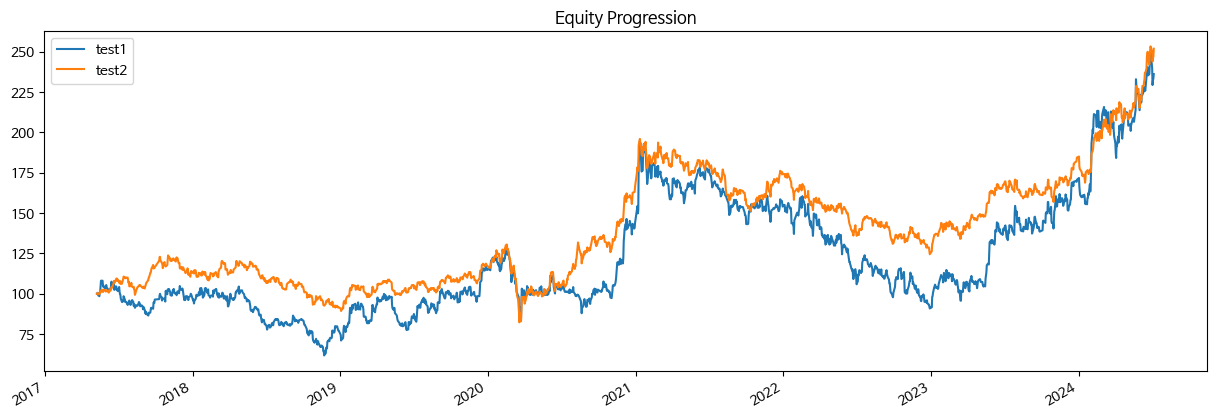

In [72]:
n = 1

algos = [
    bt.algos.SelectAll(),
    #bt.algos.SelectMomentum(12,20),
    AlgoSelectFinRatio(df_r, n), 
    bt.algos.RunYearly(), 
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
]
s1 = bt.Strategy('test1', algos)

b1 = bt.Backtest(s1, df_data)


algos = [
    bt.algos.SelectAll(),
    #bt.algos.SelectMomentum(12,20),
    bt.algos.RunYearly(), 
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
]
s2 = bt.Strategy('test2', algos)

b2 = bt.Backtest(s2, df_data)

res = bt.run(b1, b2)
res.plot()

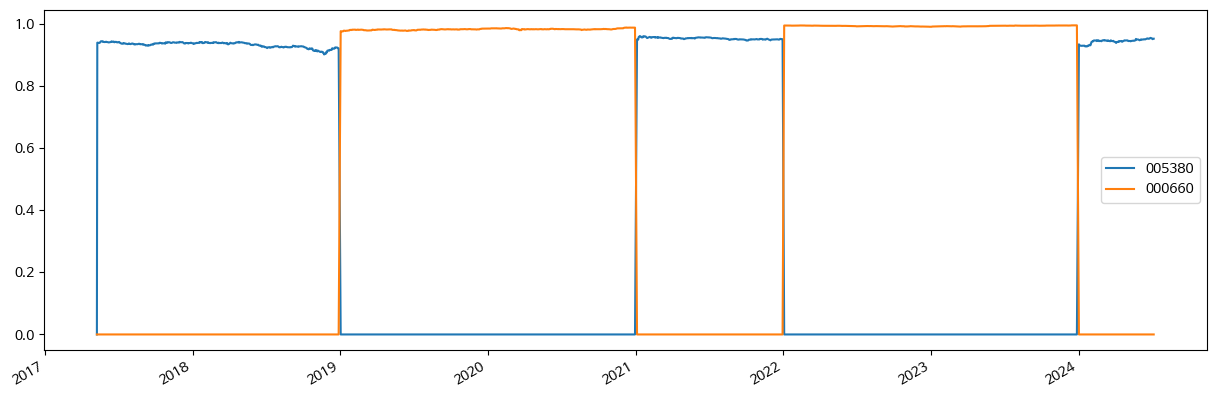

In [73]:
res.plot_security_weights()

## testing

In [1]:
from pykrx import stock as pyk

In [5]:
%%time

start = '2010-01-01'
end = '2023-12-31'
ticker = "005930"
freq="m"

df = pyk.get_market_fundamental(start, end, ticker, freq=freq)

CPU times: user 117 ms, sys: 7.48 ms, total: 125 ms
Wall time: 21.3 s


/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/pykrx/stock/stock_api.py:46: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').apply(how)


In [15]:
df.head()

,BPS,PER,PBR,EPS,DIV,DPS
날짜,,,,,,
2010-01-31,457368,21.47,1.77,37684,0.68,5500
2010-02-28,457368,20.62,1.70,37684,0.71,5500
2010-03-31,457368,20.43,1.68,37684,0.71,5500
2010-04-30,457368,22.42,1.85,37684,0.65,5500
2010-05-31,508420,12.66,1.63,65499,0.97,8000


In [18]:
df.assign(ticker=ticker).set_index('ticker', append=True)

,,BPS,PER,PBR,EPS,DIV,DPS
날짜,ticker,,,,,,
2010-01-31,005930,457368,21.47,1.77,37684,0.68,5500
2010-02-28,005930,457368,20.62,1.70,37684,0.71,5500
2010-03-31,005930,457368,20.43,1.68,37684,0.71,5500
2010-04-30,005930,457368,22.42,1.85,37684,0.65,5500
2010-05-31,005930,508420,12.66,1.63,65499,0.97,8000
...,...,...,...,...,...,...,...
2023-08-31,005930,50817,8.82,1.40,8057,2.03,1444
2023-09-30,005930,50817,8.81,1.40,8057,2.03,1444
2023-10-31,005930,50817,8.38,1.33,8057,2.14,1444


<Axes: xlabel='날짜'>

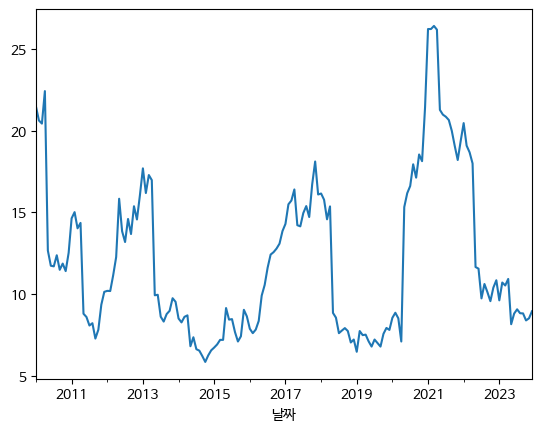

In [7]:
df.PER.plot()

## testing

In [7]:
from pf_utils import DataManager, TimeTracker
from pykrx import stock as pyk

In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

In [3]:
# universe and file
uv_k200 = ['kospi200', 'kospi200_prices.csv']
uv_krx = ['krx', 'krx_prices.csv']
uv_etf  = ['etf', 'etfs_all.csv']
uv_irp  = ['fund', 'funds_irp.csv']
uv_hana = ['fund', 'funds_kebhana.csv']

In [4]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-08 uploaded.
df_prices updated


In [5]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [9]:
import pandas as pd
from tqdm import tqdm

date_format = '%Y-%m-%d'
start = df_k200.index.min().strftime(date_format)
end = df_k200.index.max().strftime(date_format)
freq = 'm'

interval = 50
pause_duration = 2
msg = False

tracker = TimeTracker(auto_start=True)
df_ratios = pd.DataFrame()

for ticker in tqdm(df_k200.columns):
    df = pyk.get_market_fundamental(start, end, ticker, freq=freq)
    df = df.assign(ticker=ticker).set_index('ticker', append=True)
    df_ratios = pd.concat([df_ratios, df])
    tracker.pause(interval=interval, pause_duration=pause_duration, msg=msg)
    
    if tracker.pause_count == 2:
        break
tracker.stop()

df_ratios = df_ratios.rename_axis(['date', 'ticker']).swaplevel()

  9%|█████▌                                                        | 18/201 [01:48<18:24,  6.04s/it]


In [22]:
df_ratios.rename_axis(['date', 'ticker']).swaplevel()

BPS    PER   PBR    EPS   DIV   DPS
ticker date                                              
005930 2021-01-31   37528  26.22  2.21   3166  1.71  1416
       2021-02-28   37528  26.22  2.21   3166  1.71  1416
       2021-03-31   37528  26.41  2.23   3166  1.69  1416
       2021-04-30   37528  26.18  2.21   3166  1.71  1416
       2021-05-31   39406  21.27  2.07   3841  3.66  2994
...                   ...    ...   ...    ...   ...   ...
086790 2024-06-30  136601   5.51  0.46  11380  5.42  3400
       2024-07-31  136601   5.29  0.44  11380  5.65  3400
       2024-08-31  136601   5.67  0.47  11380  5.27  3400
       2024-09-30  136601   5.57  0.46  11380  5.36  3400
       2024-10-31  136601   5.23  0.44  11380  5.71  3400

[862 rows x 6 columns]

In [26]:
df_ratios.swaplevel()

BPS    PER   PBR    EPS   DIV   DPS
ticker 날짜                                                
005930 2021-01-31   37528  26.22  2.21   3166  1.71  1416
       2021-02-28   37528  26.22  2.21   3166  1.71  1416
       2021-03-31   37528  26.41  2.23   3166  1.69  1416
       2021-04-30   37528  26.18  2.21   3166  1.71  1416
       2021-05-31   39406  21.27  2.07   3841  3.66  2994
...                   ...    ...   ...    ...   ...   ...
086790 2024-06-30  136601   5.51  0.46  11380  5.42  3400
       2024-07-31  136601   5.29  0.44  11380  5.65  3400
       2024-08-31  136601   5.67  0.47  11380  5.27  3400
       2024-09-30  136601   5.57  0.46  11380  5.36  3400
       2024-10-31  136601   5.23  0.44  11380  5.71  3400

[862 rows x 6 columns]

In [37]:
k200.g(True)

,005930,000660,373220,005380,207940,000270,068270,105560,005490,055550,...,105630,093370,039130,032350,178920,285130,009900,016380,005250,000670
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-17,72500.0,129900.0,432000.0,184400.0,723000.0,85200.0,168400.0,54600.0,463500.0,36100.0,...,23350.0,11016.0,51700.0,10850.0,29350.0,62800.0,17850.0,8060.0,15230.0,508000.0
2023-11-20,72700.0,131400.0,444000.0,183600.0,720000.0,84400.0,169900.0,53900.0,472000.0,36300.0,...,23050.0,11221.0,52300.0,10920.0,29450.0,63500.0,18780.0,8120.0,15100.0,509000.0
2023-11-21,72800.0,132000.0,447000.0,184200.0,722000.0,83600.0,172200.0,54100.0,474000.0,36950.0,...,23550.0,11358.0,53400.0,10900.0,29700.0,64600.0,19340.0,8170.0,15250.0,508000.0
2023-11-22,72800.0,131300.0,442000.0,183000.0,721000.0,83100.0,172300.0,54500.0,472000.0,36850.0,...,22950.0,11426.0,54900.0,10500.0,29850.0,64700.0,19400.0,8170.0,15150.0,505000.0
2023-11-23,72400.0,130100.0,448500.0,184800.0,721000.0,84500.0,172900.0,54300.0,475000.0,36950.0,...,22200.0,11319.0,54900.0,10460.0,31050.0,64900.0,19450.0,8220.0,15220.0,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,81800.0,235500.0,347000.0,286000.0,759000.0,128600.0,184100.0,79600.0,370500.0,47850.0,...,19700.0,7480.0,58400.0,9880.0,27150.0,49200.0,14240.0,6460.0,14130.0,338500.0
2024-07-02,81800.0,232000.0,343500.0,272500.0,810000.0,123600.0,184500.0,83200.0,365500.0,49500.0,...,19460.0,7210.0,56000.0,9680.0,27600.0,48200.0,14390.0,6480.0,14010.0,336000.0
2024-07-03,81800.0,236000.0,358000.0,276000.0,810000.0,123700.0,181800.0,84400.0,370500.0,51100.0,...,18750.0,7300.0,55800.0,9550.0,27050.0,47850.0,14690.0,6410.0,13010.0,332000.0


## class

In [1]:
from pf_utils import DataManager, TimeTracker
from pykrx import stock as pyk

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

In [3]:
# universe and file
uv_k200 = ['kospi200', 'kospi200_prices.csv']
uv_krx = ['krx', 'krx_prices.csv']
uv_etf  = ['etf', 'etfs_all.csv']
uv_irp  = ['fund', 'funds_irp.csv']
uv_hana = ['fund', 'funds_kebhana.csv']

In [4]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

201 assets from 2021-01-04 to 2024-10-08 uploaded.
df_prices updated


In [5]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [97]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from pf_utils import get_file_latest, get_filename, save_dataframe


class FinancialRatios():
    def __init__(self, file, path='.', date_format='%Y-%m-%d',
                 cols_index={'date':'date', 'ticker':'ticker'},
                 ratios={'BPS':False, 'PER':True, 'PBR':True, 
                         'EPS':False, 'DIV':False, 'DPS':False}):
        self.file = get_file_latest(file, path) # latest file
        self.path = path
        self.date_format = date_format
        self.ratios = ratios # ratios and its ascending order
        self.cols_index = cols_index
        self.df_ratios = None


    def upload(self):
        """
        load financial ratios from a file
        """
        if self.file is None:
            return print('ERROR: Download first')
        else:
            col_ticker = self.cols_index['ticker']
            f = f'{self.path}/{self.file}'
            df_ratios = pd.read_csv(f, index_col=[0,1], parse_dates=[1], dtype={col_ticker:str})
            self.df_ratios = df_ratios
            return self._print_info(df_ratios, str_sfx='loaded')
        

    def download(self, tickers, start, end=None, freq='m', save=True,
                 # args for TimeTracker.pause
                 interval=50, pause_duration=2, msg=False):
        col_date = self.cols_index['date']
        col_ticker = self.cols_index['ticker']
        if end is None:
            end = datetime.today().strftime(self.date_format)
        
        tracker = TimeTracker(auto_start=True)
        df_ratios = pd.DataFrame()
        
        for ticker in tqdm(tickers):
            df = pyk.get_market_fundamental(start, end, ticker, freq=freq)
            df = df.assign(**{col_ticker:ticker})
            df_ratios = pd.concat([df_ratios, df])
            tracker.pause(interval=interval, pause_duration=pause_duration, msg=msg)
        tracker.stop()
        
        df_ratios = (df_ratios.rename_axis(col_date)
                     .loc[df_ratios.index <= end] # remove fictitious end date of month
                     .set_index(col_ticker, append=True)
                     .swaplevel())
        self._print_info(df_ratios, str_sfx='downloaded')
        self.df_ratios = df_ratios
        if save:
            self.save(self.file, self.path)

    
    def save(self, file=None, path=None, date_format='%y%m%d'):
        """
        date_format: date format for file name
        """
        file = self._check_var(file, self.file)
        path = self._check_var(path, self.path)
        df_ratios = self.df_ratios
        if (file is None) or (df_ratios is None):
            return print('ERROR: check file or df_ratios')

        date = df_ratios.index.get_level_values(1).max().strftime(date_format)
        file = get_filename(file, f'_{date}', r"_\d+(?=\.\w+$)")
        _ = save_dataframe(df_ratios, file, path, msg_succ=f'{file} saved',
                           msg_fail=f'ERROR: failed to save as {file} exists')
        return None


    def get_ratios(self, date=None, metrics=None):
        """
        metrics: list or str
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        else:
            date = self._check_date(df_ratios, date)
            if date is None:
                return None

        if metrics is None:
            metrics = df_ratios.columns.to_list()

        col_date = self.cols_index['date']
        df_res = self._get_ratio(df_ratios, date, metrics).droplevel(col_date)

        metrics = '/'.join(metrics) if isinstance(metrics, list) else metrics
        print(f'{metrics} on {date}')
        return df_res
    

    def calc_rank(self, date=None, metrics='PER', topn=10, scale='minmax'):
        """
        calc the rank of financial ratios
        metrics: list or str
        """
        df_ratios = self.df_ratios
        if df_ratios is None:
            return print('ERROR: load ratios first')
        else:
            date = self._check_date(df_ratios, date)
            if date is None:
                return None

        if isinstance(metrics, str):
            metrics = [metrics]

        if len(metrics) > 1:
            if scale not in ['minmax', 'zscore']:
                return print('ERROR: Set scale to sum up multiple ranks')
        
        res_rank = None
        for m in metrics:
            sr_rank = self._calc_rank(df_ratios, date, m, scale)
            if res_rank is None:
                res_rank = sr_rank
            else:
                res_rank += sr_rank 
                
        metrics = '+'.join(metrics)
        print(f'Top {topn} stocks of low {metrics} on {date}')
        col_date = self.cols_index['date']
        return res_rank.droplevel(col_date).sort_values(ascending=True).iloc[:topn]


    def _get_ratio(self, df_ratios, date, metrics):
        """
        get financial ratios on date
        metrics: list or str
        """
        try:
            idx = pd.IndexSlice
            return df_ratios.loc[idx[:,date], metrics]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
        

    def _calc_rank(self, df_ratios, date, metric, scale, drop_zero=True):
        """
        calc the rank of a financial ratio
        metric: str
        """
        sr_ratio = self._get_ratio(df_ratios, date, metric)
        if sr_ratio is None:
            return # see _get_ratio for error msg
        
        if drop_zero:
           sr_ratio = sr_ratio.loc[sr_ratio>0]
            
        ascending = self.ratios[metric]
        sr_rank = sr_ratio.rank(ascending=ascending)

        # scale rank
        if scale == 'minmax':
            sr_rank = (sr_rank-sr_rank.min()) / (sr_rank.max()-sr_rank.min())
        elif scale == 'zscore':
            sr_rank  = (sr_rank-sr_rank.mean()) / sr_rank.std()
        else:
            pass
        return sr_rank


    def _check_date(self, df_ratios, date, return_str=True):
        """
        check if date in df_ratios
        """
        dates = df_ratios.index.get_level_values(1).unique()
        if date is not None:
            cond = (dates <= date)
            if cond.sum() == 0:
                return print('ERROR: check date')
            else:
                dates = dates[cond]
        date = dates.max()
        if return_str:
            date = date.strftime(self.date_format)
        return date

    
    def _print_info(self, df, str_pfx='Financial ratios of', str_sfx=''):
        date_format = self.date_format
        dts = df.index.get_level_values(1)
        dt0 = dts.min().strftime(date_format)
        dt1 = dts.max().strftime(date_format)
        n = df.index.get_level_values(0).nunique()
        s1  = str_pfx + " " if str_pfx else ""
        s2  = " " + str_sfx if str_sfx else ""
        return print(f'{s1}{n} stocks from {dt0} to {dt1}{s2}')
        

    def _check_var(self, var_arg, var_self):
        return var_self if var_arg is None else var_arg

    


In [98]:
file = 'test.csv'
path = 'data'
fr = FinancialRatios(file, path)
fr.upload()
fr.df_ratios

Financial ratios of 5 stocks from 2024-01-31 to 2024-09-30 loaded


BPS    PER   PBR    EPS   DIV    DPS
ticker date                                               
068270 2024-01-31   28937  61.72  8.00   3751  0.16    375
       2024-02-29   28937  47.64  6.18   3751  0.21    375
       2024-03-31   28937  46.95  6.09   3751  0.21    375
       2024-04-30   28937  50.15  6.50   3751  0.20    375
       2024-05-31   81950  49.88  2.29   3759  0.27    500
       2024-06-30   81950  47.62  2.18   3759  0.28    500
       2024-07-31   81950  48.98  2.25   3759  0.27    500
       2024-08-31   81950  53.21  2.44   3759  0.25    500
       2024-09-30   81950  52.43  2.41   3759  0.25    500
000270 2024-01-31   98117   7.23  0.99  13495  3.59   3500
       2024-02-29   98117   7.88  1.08  13495  3.29   3500
       2024-03-31   98117   9.31  1.28  13495  2.79   3500
       2024-04-30   98117   8.05  1.11  13495  3.22   3500
       2024-05-31  117495   5.40  1.02  22168  4.68   5600
       2024-06-30  117495   5.44  1.03  22168  4.64   5600
       2024-07-31  117495   5.80  1.09  22168  4.35   5600
       2024-08-31  117495   5.06  0.95  22168  5.00   5600
       2024-09-30  117495   4.79  0.90  22168  5.28   5600
105560 2024-01-31  124124   4.89  0.43  10955  5.50   2950
       2024-02-29  124124   5.60  0.49  10955  4.81   2950
       2024-03-31  124124   6.30  0.56  10955  4.28   2950
       2024-04-30  124124   6.24  0.55  10955  4.31   2950
       2024-05-31  150344   6.24  0.48  11580  4.23   3060
       2024-06-30  150344   6.85  0.53  11580  3.86   3060
       2024-07-31  150344   6.87  0.53  11580  3.84   3060
       2024-08-31  150344   7.63  0.59  11580  3.47   3060
       2024-09-30  150344   7.57  0.58  11580  3.49   3060
005490 2024-01-31  692323  11.77  0.70  41456  2.46  12000
       2024-02-29  692323  10.54  0.63  41456  2.75  12000
       2024-03-31  692323  11.05  0.66  41456  2.62  12000
       2024-04-30  692323  10.08  0.60  41456  2.87  12000
       2024-05-31  714069  17.83  0.56  22382  2.51  10000
       2024-06-30  714069  16.71  0.52  22382  2.67  10000
       2024-07-31  714069  16.55  0.52  22382  2.70  10000
       2024-08-31  714069  16.20  0.51  22382  2.76  10000
       2024-09-30  714069  16.08  0.50  22382  2.78  10000
055550 2024-01-31   92043   4.65  0.43   8454  5.25   2065
       2024-02-29   92043   5.03  0.46   8454  4.86   2065
       2024-03-31   92043   5.23  0.48   8454  4.67   2065
       2024-04-30   92043   5.39  0.49   8454  4.53   2065
       2024-05-31  104769   5.69  0.44   8048  4.59   2100
       2024-06-30  104769   5.84  0.45   8048  4.47   2100
       2024-07-31  104769   5.95  0.46   8048  4.39   2100
       2024-08-31  104769   7.54  0.58   8048  3.46   2100
       2024-09-30  104769   7.00  0.54   8048  3.73   2100

In [99]:
tickers = df_k200.columns.to_list()[5:10]

In [100]:
fr.get_ratios()
#fr.get_ratios(metrics='PER')

BPS/PER/PBR/EPS/DIV/DPS on 2024-09-30


,BPS,PER,PBR,EPS,DIV,DPS
ticker,,,,,,
068270,81950,52.43,2.41,3759,0.25,500
000270,117495,4.79,0.90,22168,5.28,5600
105560,150344,7.57,0.58,11580,3.49,3060
005490,714069,16.08,0.50,22382,2.78,10000
055550,104769,7.00,0.54,8048,3.73,2100


In [101]:
#fr.calc_rank(metrics=['PBR', 'PER', 'EPS'], topn=None)
#fr.calc_rank(metrics='PER', topn=None)
fr.calc_rank(metrics=['PBR', 'PER'], scale=None)

ERROR: Set scale to sum up multiple ranks


In [ ]:
from pf_utils import performance_stats
df = df_k200.loc[df_k200.index >= date, tickers]
performance_stats(df)

https://www.investopedia.com/terms/c/cross_sectional_analysis.asp

In [102]:
file = 'test.csv'
path = 'data'
#tickers = ['086790']
start = '2024-01-01'
fr = FinancialRatios(file, path)

In [ ]:
#fr.download(tickers, start)
#fr.df_ratios

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]

8.4 secs elapsed, 0.0 secs paused (0.0%)
Financial ratios of 5 stocks from 2024-01-31 to 2024-09-30 downloaded
test_240930.csv saved


In [105]:
fr.upload()
fr.calc_rank(metrics='PER', date='2024-05-01')

Financial ratios of 5 stocks from 2024-01-31 to 2024-09-30 loaded
PER rank on 2024-04-30


ticker
055550    0.00
105560    0.25
000270    0.50
005490    0.75
068270    1.00
Name: PER, dtype: float64

In [106]:
fr.get_ratios(metrics='PER', date='2024-05-01')

PER on 2024-04-30


ticker
068270    50.15
000270     8.05
105560     6.24
005490    10.08
055550     5.39
Name: PER, dtype: float64

## class

In [12]:
df_k200

,005930,000660,005380,207940,000270,068270,105560,005490,055550,028260,...,001680,114090,105630,093370,039130,032350,178920,016380,005250,000670
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-10,45600.0,55600.0,156500.0,177893.0,36100.0,87191.0,53000.0,270000.0,49300.0,124500.0,...,25050.0,22150.0,27350.0,7236.0,85962.0,6977.0,18050.0,48500.0,33500.0,948000.0
2017-05-11,45500.0,56400.0,157500.0,182835.0,36850.0,86106.0,53900.0,270500.0,50800.0,126500.0,...,25400.0,23100.0,27100.0,7412.0,87036.0,7203.0,17800.0,50333.0,33550.0,960000.0
2017-05-12,45820.0,55300.0,155000.0,182835.0,36500.0,86287.0,52900.0,272500.0,50100.0,125500.0,...,25450.0,22800.0,26300.0,7402.0,85766.0,7330.0,17650.0,50167.0,32400.0,962000.0
2017-05-15,46100.0,55600.0,154000.0,184317.0,36800.0,86649.0,54000.0,271000.0,50100.0,125500.0,...,25850.0,22700.0,25900.0,7383.0,86450.0,7321.0,17600.0,49167.0,33200.0,965000.0
2017-05-16,46380.0,55300.0,157500.0,184811.0,36900.0,85745.0,54000.0,273000.0,49900.0,126500.0,...,25800.0,22600.0,24200.0,7529.0,87232.0,7429.0,17200.0,49500.0,32500.0,958000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,81800.0,235500.0,286000.0,759000.0,128600.0,184100.0,79600.0,370500.0,47850.0,140800.0,...,26500.0,12670.0,19700.0,7480.0,58400.0,9880.0,27150.0,6460.0,14130.0,338500.0
2024-07-02,81800.0,232000.0,272500.0,810000.0,123600.0,184500.0,83200.0,365500.0,49500.0,141200.0,...,26100.0,12500.0,19460.0,7210.0,56000.0,9680.0,27600.0,6480.0,14010.0,336000.0
2024-07-03,81800.0,236000.0,276000.0,810000.0,123700.0,181800.0,84400.0,370500.0,51100.0,142300.0,...,25500.0,12260.0,18750.0,7300.0,55800.0,9550.0,27050.0,6410.0,13010.0,332000.0


In [190]:
file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)
fr.upload()

Financial ratios of 3 stocks from 2017-05-31 to 2024-09-30 loaded


In [114]:
tickers = fr.df_ratios.index.get_level_values(0).unique()
df_prc = df_k200[tickers]
df_prc = df_prc.unstack().rename_axis(['ticker','date'])
df_prc

ticker  date      
005930  2017-05-10     45600.0
        2017-05-11     45500.0
        2017-05-12     45820.0
        2017-05-15     46100.0
        2017-05-16     46380.0
                        ...   
005380  2024-07-01    286000.0
        2024-07-02    272500.0
        2024-07-03    276000.0
        2024-07-04    277500.0
        2024-07-05    281000.0
Length: 5283, dtype: float64

In [128]:
df_ratios = fr.df_ratios.copy()
df_r = df_ratios['PER'].copy()
df_r

ticker  date      
005930  2017-05-31    14.43
        2017-06-30    14.14
        2017-07-31    14.95
        2017-08-31    15.38
        2017-09-30    14.71
                      ...  
005380  2024-05-31     5.45
        2024-06-30     5.80
        2024-07-31     6.26
        2024-08-31     5.55
        2024-09-30     5.38
Name: PER, Length: 267, dtype: float64

In [129]:
import pandas as pd

# get price at the end date of every month
df_p = df_prc.groupby([pd.Grouper(level=0), pd.Grouper(level=1, freq='M')]).last().rename('price')

# update date index as year & date
reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period('M'), level=1)
df_r.index = reset_index(df_r)
df_p.index = reset_index(df_p)

In [131]:
df = df_r.to_frame().join(df_p).dropna()
df['mpl'] = df.apply(lambda x: x.PER / x.price, axis=1)
df

PER     price       mpl
ticker date                              
005930 2017-05  14.43   44700.0  0.000323
       2017-06  14.14   47540.0  0.000297
       2017-07  14.95   48200.0  0.000310
       2017-08  15.38   46320.0  0.000332
       2017-09  14.71   51280.0  0.000287
...               ...       ...       ...
005380 2024-03   8.96  233000.0  0.000038
       2024-04   7.98  251000.0  0.000032
       2024-05   5.45  253000.0  0.000022
       2024-06   5.80  295000.0  0.000020
       2024-07   6.26  281000.0  0.000022

[261 rows x 3 columns]

In [180]:
(df_prc.rename('price').reset_index(level=1)
       .assign(**{'ym': lambda x: x.date.dt.to_period('M')})
 .join(df.mpl, on=['ticker', 'ym'])
 .set_index('date', append=True)
 .apply(lambda x: x.price * x.mpl, axis=1)
 #.rename('PER')
 .unstack(0)
)

ticker,000660,005380,005930
date,,,
2017-05-10,12.963579,7.469755,14.720537
2017-05-11,13.150105,7.517485,14.688255
2017-05-12,12.893632,7.398160,14.791557
2017-05-15,12.963579,7.350429,14.881946
2017-05-16,12.893632,7.517485,14.972336
...,...,...,...
2024-07-01,0.000000,6.371388,36.053984
2024-07-02,0.000000,6.070641,36.053984
2024-07-03,0.000000,6.148612,36.053984


In [211]:
import pandas as pd


file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)
fr.upload()


self = fr


def interpolate_bk(self, df_prices, metric='PER', freq='M'):
    df_ratios = self.df_ratios
    if df_ratios is None:
        return print('ERROR')

    col_ticker = self.cols_index['ticker']
    col_date = self.cols_index['date']
    col_price='price'
    col_mpl = 'multiplier'
    col_ym = 'year_month'
    
    # df_ratios[metric] modified forever if not copy
    df_r = df_ratios[metric].copy() 
    
    # get price at the end date of every month
    by = [pd.Grouper(level=0), pd.Grouper(level=1, freq=freq)]
    df_p = df_prices.groupby(by).last().rename(col_price)
    
    # update date index as year & date
    reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period(freq), level=1)
    df_r.index = reset_index(df_r)
    df_p.index = reset_index(df_p)

    df_r = df_r.to_frame().join(df_p).dropna()
    df_r[col_mpl] = df_r.apply(lambda x: x[metric] / x[col_price], axis=1)

    return (df_prices.rename(col_price).reset_index(level=1)
            .assign(**{col_ym: lambda x: x.date.dt.to_period(freq)})
            .join(df_r[col_mpl], on=[col_ticker, col_ym])
            .set_index(col_date, append=True)
            .apply(lambda x: x[col_price] * x[col_mpl], axis=1)
            .unstack(0))
    
    
def interpolate(self, df_prices, metric='PER', freq='M'):
    df_ratios = self.df_ratios
    if df_ratios is None:
        return print('ERROR')

    col_ticker = self.cols_index['ticker']
    col_date = self.cols_index['date']
    col_price='price'
    col_mpl = 'multiplier'
    col_ym = 'year_month'
    
    # Copy metric column to avoid modifying original
    df_m = df_ratios[metric].copy() 
    
    # Get price at the end date of every month
    by = [pd.Grouper(level=0), pd.Grouper(level=1, freq=freq)]
    df_p = df_prices.groupby(by).last().rename(col_price)
    
    # Update date index to year and month
    reset_index = lambda x: x.index.set_levels(x.index.levels[1].to_period(freq), level=1)
    df_m.index = reset_index(df_m)
    df_p.index = reset_index(df_p)

    # Calculate multiplier from price and metric
    df_m = (df_m.to_frame().join(df_p).dropna()
            .apply(lambda x: x[metric] / x[col_price], axis=1).rename(col_mpl))

    # Return interpolated ratios
    return (df_prices.rename(col_price).reset_index(level=1)
            .assign(**{col_ym: lambda x: x[col_date].dt.to_period(freq)})
            .join(df_m, on=[col_ticker, col_ym])
            .set_index(col_date, append=True)
            .apply(lambda x: x[col_price] * x[col_mpl], axis=1)
            #.unstack(0)
           )


tickers = fr.df_ratios.index.get_level_values(0).unique()
df_prc = df_k200[tickers]
df_prc = df_prc.unstack().rename_axis(['ticker','date'])
df_prc

interpolate(self, df_prc)

Financial ratios of 3 stocks from 2017-05-31 to 2024-09-30 loaded


ticker  date      
005930  2017-05-10    14.720537
        2017-05-11    14.688255
        2017-05-12    14.791557
        2017-05-15    14.881946
        2017-05-16    14.972336
                        ...    
005380  2024-07-01     6.371388
        2024-07-02     6.070641
        2024-07-03     6.148612
        2024-07-04     6.182028
        2024-07-05     6.260000
Length: 5283, dtype: float64

In [212]:
df_prc

ticker  date      
005930  2017-05-10     45600.0
        2017-05-11     45500.0
        2017-05-12     45820.0
        2017-05-15     46100.0
        2017-05-16     46380.0
                        ...   
005380  2024-07-01    286000.0
        2024-07-02    272500.0
        2024-07-03    276000.0
        2024-07-04    277500.0
        2024-07-05    281000.0
Length: 5283, dtype: float64